# Modeling and Interpretation

## 0. Import libraries

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

## 1. Data Processing

In [4]:
# Create new dataset
data_model = data[['RID','AGE', 'PTGENDER', 'PTMARRY', 'APOE4', 'ADAS13', 'RAVLT_immediate', 'RAVLT_learning', 'TMT_PtB_Complete', 
                   'ABETA', 'TAU', 'RAVLT_forgetting', 'MH16SMOK', 'CATANIMSC', 'high_homocysteine','MCI_reversion_2y',]]
data_model.head()

,RID,AGE,PTGENDER,PTMARRY,APOE4,ADAS13,RAVLT_immediate,RAVLT_learning,TMT_PtB_Complete,ABETA,TAU,RAVLT_forgetting,MH16SMOK,CATANIMSC,high_homocysteine,MCI_reversion_2y
0,6,80.4,Female,Married,0,25.67,30,1,168.0,NaN,NaN,5,0,13,0,0
1,33,83.3,Male,Married,0,25.67,21,4,NaN,129.0,110.0,6,1,16,0,0
2,51,66.5,Male,Married,2,17.67,29,1,94.0,92.5,83.1,4,0,9,0,0
3,80,85.0,Male,Married,1,21.00,23,4,81.0,NaN,NaN,3,0,17,0,0
4,98,84.4,Female,Unmarried,1,17.67,25,4,167.0,NaN,NaN,5,1,17,0,0


** Before we start fitting classification models, we notice that there are some values in the three biomarkers columns are missing.**

In [5]:
# Number of observations with missing data
print('Number of observations with missing predictors is', len(data)-len(data.dropna()))

Number of observations with missing predictors is 141


In [6]:
# Check missings for each predictors
pd.DataFrame(data_model.isnull().sum(), columns=['Number of missing'])

,Number of missing
RID,0
AGE,0
PTGENDER,0
PTMARRY,0
APOE4,0
ADAS13,1
RAVLT_immediate,0
RAVLT_learning,0
TMT_PtB_Complete,13
ABETA,86


In [7]:
# Drop predictors with missing value
data_model = data_model.drop(['TMT_PtB_Complete','ABETA','TAU','RID'],1)

**Missing Data Problem**
<br/>We choose to drop predictors instead of dropping observations since we only have 186 observations in our data set. We explained in our report why we did not impute the values.

In [8]:
# Divide the data for modeling into training and test set using the same seed used for EDA
np.random.seed(9001)
msk = np.random.rand(len(data_model)) < 0.6
data_train = data_model[msk]
data_test = data_model[~msk]

data_train = data_train[np.isfinite(data_train['ADAS13'])]
data_test = data_test[np.isfinite(data_test['ADAS13'])]

X_train = data_train.drop('MCI_reversion_2y',1)
y_train = data_train['MCI_reversion_2y'].values
X_test = data_test.drop('MCI_reversion_2y',1)
y_test = data_test['MCI_reversion_2y'].values

In [9]:
# Pre-process the categorical attributes - create dummy variables
attr_cats = ['PTGENDER', 'PTMARRY', 'APOE4']
x_train = pd.get_dummies(X_train, columns=attr_cats, drop_first=True)
x_test = pd.get_dummies(X_test, columns=attr_cats, drop_first=True)

# Pre-process the numerical attributes - standardize the variables
attr_nums = ['AGE', 'RAVLT_immediate', 'RAVLT_learning','RAVLT_forgetting', 'ADAS13', 'CATANIMSC']

means = {attr_num: np.mean(x_train[attr_num]) for attr_num in attr_nums}
sds = {attr_num: np.std(x_train[attr_num], ddof=1) for attr_num in attr_nums}

for attr_num in attr_nums:
    x_train[attr_num] = (x_train[attr_num] - means[attr_num]) / sds[attr_num]
    x_test[attr_num] = (x_test[attr_num] - means[attr_num]) / sds[attr_num]

- ** Data was split into 60% training set and 40% test set. **
- ** All continous variables were standardized:**
<br/> The majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. We notice that the range of values of raw data varies widely, these continuous features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [10]:
print('Number of cases in the training set is', np.sum(y_train))

Number of cases in the training set is 6


**Imbalanced Data Problem**
<br/> There are many more patiants that didn't reverse (Y = 0) than reversed subjects (Y = 1). Therefore, classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we use the confusion matrix to evaluate the classifier.

## 2. PCA Analysis

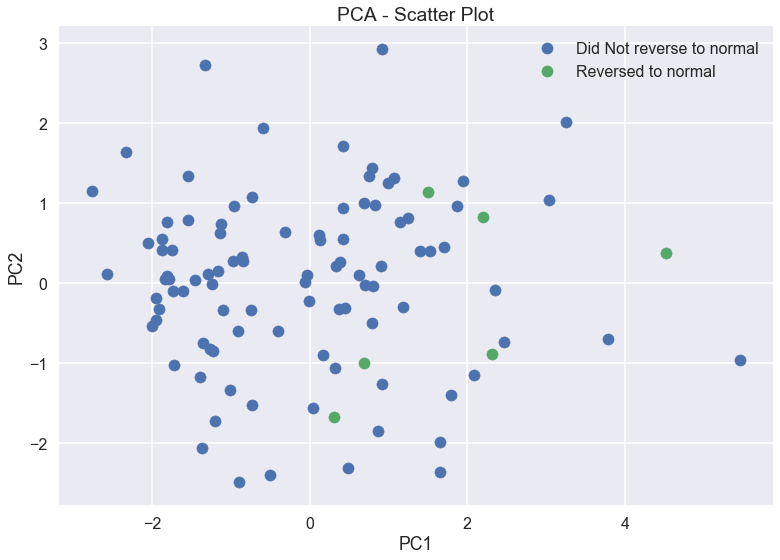

In [11]:
# Find the top two principal components for the gene expression data
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

# Create a dataset for the top two principle components
train_pca = pd.DataFrame({'MCI reversion': y_train})
train_pca['pc1'] = x_train_pca[:,0]
train_pca['pc2'] = x_train_pca[:,1]

# Generate a scatter plot
plt.scatter(train_pca[train_pca['MCI reversion']==0]['pc1'], train_pca[train_pca['MCI reversion']==0]['pc2'], label='Did Not reverse to normal')
plt.scatter(train_pca[train_pca['MCI reversion']==1]['pc1'], train_pca[train_pca['MCI reversion']==1]['pc2'], label='Reversed to normal ')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Scatter Plot')
plt.legend();

**PCA**
<br/>Each dot here represents a sample. Patients who did not reverse to normal are clustering on the left; patients who reversed to normal are clustering on the right.  

## 3. Classification Models

In [12]:
# Functions to calculate TPR and FPR
def tpr(confusion_matrix):
    return confusion_matrix[1][1]/np.sum(confusion_matrix[1])
def fpr(confusion_matrix):
    return confusion_matrix[0][1]/np.sum(confusion_matrix[0])

### a. Logistic Regression
We use L2 regularization in logistic regression, with the regularization parameter tuned using 5 fold cross-validation.

In [13]:
# Logistic Regression 
logistic = LogisticRegressionCV(cv=5, penalty='l2').fit(x_train, y_train)
logistic_acc_train = logistic.score(x_train, y_train)
logistic_acc_test = logistic.score(x_test, y_test)
cm_log = metrics.confusion_matrix(y_train, logistic.predict(x_train))
auc_log = metrics.roc_auc_score(y_train, logistic.predict_proba(x_train)[:,1])
auc_log_test = metrics.roc_auc_score(y_test, logistic.predict_proba(x_test)[:,1])

### b. Linear Discriminant Analysis

In [14]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
lda_acc_train = lda.score(x_train, y_train)
lda_acc_test = lda.score(x_test, y_test)
cm_lda = metrics.confusion_matrix(y_train, lda.predict(x_train))
auc_lda = metrics.roc_auc_score(y_train, lda.predict_proba(x_train)[:,1])
auc_lda_test= metrics.roc_auc_score(y_test, lda.predict_proba(x_test)[:,1])

### c. k-NN
We fit k-NN regression models to the training set using different values of k (1 to 20) and choose the best k using 5 fold cross-validation.

In [15]:
# k-NN
neighbors = np.arange(1,20)

# Perform 5-fold cross validation to choose the optimal number of neighbors
cv_scores_knn = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores_knn.append(scores.mean())

# Determine the best k
optimal_k = neighbors[np.argmax(cv_scores_knn)]
print ("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 2


In [16]:
# Fit k-NN model using the optimal number of neighbors
knn = KNeighborsClassifier(optimal_k).fit(x_train, y_train)
knn_acc_train = knn.score(x_train, y_train)
knn_acc_test = knn.score(x_test, y_test)
cm_knn = metrics.confusion_matrix(y_train, knn.predict(x_train))
auc_knn= metrics.roc_auc_score(y_train, knn.predict_proba(x_train)[:,1])
auc_knn_test = metrics.roc_auc_score(y_test, knn.predict_proba(x_test)[:,1])

### d. Decision Tree
We fit decision tree models to the training set and use 5-fold cross-validation to choose the best (maximum) depth for the tree.

In [97]:
# Decision tree
depths = np.arange(2,25)

# Use 5-fold cross-validation to choose the (maximum) depth for the tree
cv_scores_dt = []
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(dt, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores_dt.append(scores.mean())

# Determine the best (maximum) depth
best_depth = depths[np.argmax(cv_scores_dt)]
print('The best maximum depth is %d'%(best_depth))

The best maximum depth is 21


In [98]:
# Fit decision tree model using the best (maximum) depth
dt = DecisionTreeClassifier(max_depth=best_depth)
dt.fit(x_train, y_train)
dt_acc_train = dt.score(x_train, y_train)
dt_acc_test = dt.score(x_test, y_test)
cm_dt = metrics.confusion_matrix(y_train, dt.predict(x_train))
auc_dt = metrics.roc_auc_score(y_train, dt.predict_proba(x_train)[:,1])
auc_dt_test = metrics.roc_auc_score(y_test, dt.predict_proba(x_test)[:,1])

### e. Random Forest
We fit random forest models to the training set and use 5-fold cross-validation to choose the optimal value for the number of predictors and trees.

In [104]:
# Use 5-fold cross-validation to choose the optimal value for the number of predictors
n_features = np.arange(1,8)
n_trees = 2**np.arange(1,9)

cv_scores_rf = {}
for n_feature in n_features:
    for n_tree in n_trees:
        rf = RandomForestClassifier(n_estimators=n_tree, max_features=n_feature, max_depth=best_depth)
        scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='accuracy')
        cv_scores_rf[(n_feature,n_tree)] = scores.mean()
        
best_n_feature, best_n_tree = max(cv_scores_rf, key=cv_scores_rf.get)
print('The optimal value for the number of predictors is %d\nThe optimal value for the number of trees is %d'%(best_n_feature,best_n_tree))

The optimal value for the number of predictors is 4
The optimal value for the number of trees is 4


In [105]:
# Fit the RF model using the optimal number of trees and the optimal number of predictors
rf = RandomForestClassifier(n_estimators=best_n_tree, max_features=best_n_feature, max_depth=best_depth)
rf.fit(x_train, y_train)
rf_acc_train = rf.score(x_train, y_train)
rf_acc_test = rf.score(x_test, y_test)
cm_rf = metrics.confusion_matrix(y_train, rf.predict(x_train))
auc_rf= metrics.roc_auc_score(y_train, rf.predict_proba(x_train)[:,1])
auc_rf_test= metrics.roc_auc_score(y_test, rf.predict_proba(x_test)[:,1])

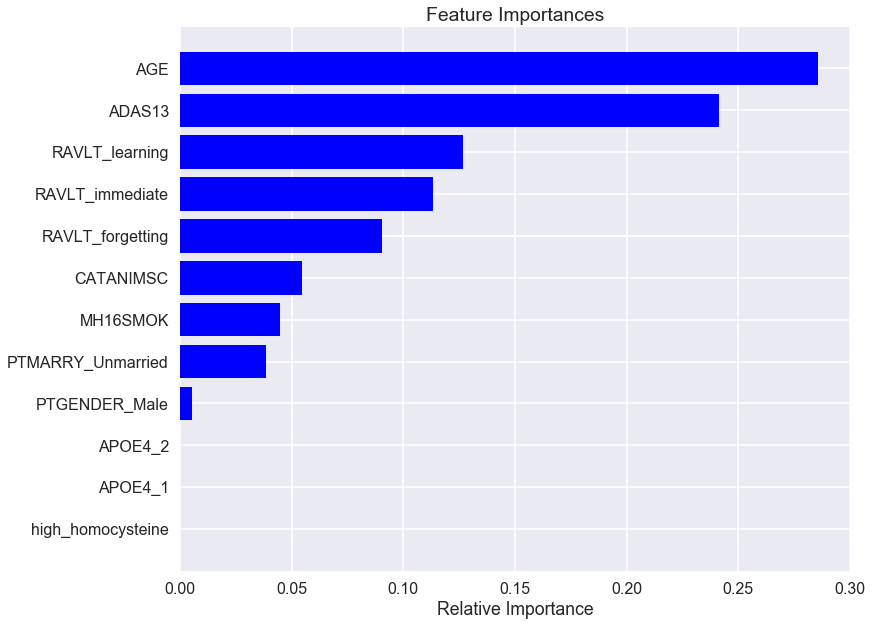

In [106]:
# Feature importance
plt.figure(figsize=(12,10))
names = x_train.columns.get_values()
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), names[indices])
plt.xlabel('Relative Importance');

### f. Boosting
We fit Boosting models to the training set and apply 5-fold cross-validation to choose the optimal number of trees for the ensemble and the optimal tree depth for the base learners.

In [86]:
# Boosting
n_tree = 2**np.arange(1,5)
depths = [2,5,10,None]

cv_scores_bo = {}
for depth in depths:
    for n in n_tree:
        adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=n, learning_rate=0.05)
        scores = cross_val_score(adaboost, x_train, y_train, cv=5, scoring='accuracy')
        cv_scores_bo[(depth,n)] = scores.mean()
best_depth, best_n_tree = max(cv_scores_bo, key=cv_scores_bo.get)
print('The optimal maximum depth is %d\nThe optimal number of trees is %d'%(best_depth, best_n_tree))

The optimal maximum depth is 2
The optimal number of trees is 16


In [87]:
# Fit the AdaBoost model using the optimal number of trees and the optimal maximum depth
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth), n_estimators=best_n_tree, learning_rate=0.05)
adaboost.fit(x_train, y_train)
adaboost_acc_train = adaboost.score(x_train, y_train)
adaboost_acc_test = adaboost.score(x_test, y_test)
cm_adaboost = metrics.confusion_matrix(y_train, adaboost.predict(x_train))
auc_adaboost= metrics.roc_auc_score(y_train, adaboost.predict_proba(x_train)[:,1])
auc_adaboost_test= metrics.roc_auc_score(y_test, adaboost.predict_proba(x_test)[:,1])

### Model Performance

In [107]:
model = ['Logistic regression','LDA','k-NN','Decision Tree','Random Forest','Adaboost']
column = ['Training accuracy','Test accuracy','True postive rate','False postive rate','AUC_training','AUC_test']

models = pd.DataFrame(index=model, columns=column)
models['Training accuracy']=[logistic_acc_train, lda_acc_train,knn_acc_train,dt_acc_train,rf_acc_train,adaboost_acc_train]
models['Test accuracy']=[logistic_acc_test, lda_acc_test,knn_acc_test,dt_acc_test,rf_acc_test,adaboost_acc_test]
models['True postive rate']=[tpr(cm_log), tpr(cm_lda),tpr(cm_knn),tpr(cm_dt),tpr(cm_rf),tpr(cm_adaboost)]
models['False postive rate']=[fpr(cm_log), fpr(cm_lda),fpr(cm_knn),fpr(cm_dt),fpr(cm_rf),fpr(cm_adaboost)]
models['AUC_training']=[auc_log, auc_lda,auc_knn,auc_dt,auc_rf,auc_adaboost]
models['AUC_test']=[auc_log_test, auc_lda_test,auc_knn_test,auc_dt_test,auc_rf_test,auc_adaboost_test]
models

,Training accuracy,Test accuracy,True postive rate,False postive rate,AUC_training,AUC_test
Logistic regression,0.941176,0.915663,0.000000,0.000000,0.878472,0.832707
LDA,0.950980,0.891566,0.333333,0.010417,0.947917,0.642857
k-NN,0.941176,0.903614,0.000000,0.000000,0.973958,0.588346
Decision Tree,1.000000,0.903614,1.000000,0.000000,1.000000,0.558271
Random Forest,0.980392,0.915663,0.666667,0.000000,1.000000,0.884398
Adaboost,1.000000,0.915663,1.000000,0.000000,1.000000,0.654135


- **Interpretation for model performance**
    - Not surprisingly, the differences of accuracies are too small for us to select the best classifier. The dataset is extremely imbalanced with the majority of non-reverters (Y=0). The classificaton accuracies are not very different from the all 0's classifier that classifies everyone as non-reverter.
    - First, we use the true postive rate to evaluate a classifier's performance. Decision tree, random forest and adaboost are better than other models since they have relatively high TPR; The false postive rates are low for all models; Then, we compare the AUC on the test set for the three selected models. Random forest has the largest AUC_test. Therefore, we select the random forest model as our final model.

### ROC curve for our best model - Random Forest

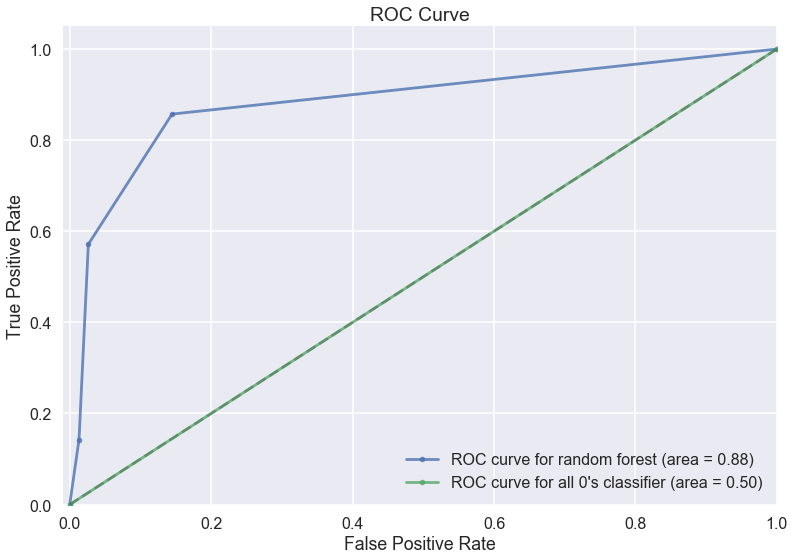

In [110]:
# Display the ROC curve for both the fitted classifier and the all 0's classifier on the test set. 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, rf.predict_proba(x_test)[:,1])
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, np.zeros(len(y_test)))
auc1 = metrics.roc_auc_score(y_test, rf.predict_proba(x_test)[:,1])
auc2 = metrics.roc_auc_score(y_test, np.zeros(len(y_test)))
plt.plot(fpr1, tpr1, '.-', alpha=0.8, label='ROC curve for random forest (area = %0.2f)' % (auc1))
plt.plot(fpr2, tpr2, '.-', alpha=0.8, label='ROC curve for all 0\'s classifier (area = %0.2f)' % (auc2))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right");

- **Interpretation for ROC curve**
<br/>The ROC curve shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity). Our ROC close to the left-hand border and then the top border of the ROC space, which indicates a good performance in terms of sensitivity and specificity for our final random forest model.